<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для интернет-магазина

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен ***инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.*** 

Обучите модель ***классифицировать комментарии на позитивные и негативные.*** В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import sys
!{sys.executable} -m pip install spacy;
!{sys.executable} -m spacy download en_core_web_sm;

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm, tqdm_notebook, notebook
import pymorphy2
import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Путь к файлам
toxic = pd.read_csv('/datasets/toxic_comments.csv')
toxic.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# Проверка типов данных
toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
# Пропорции кодировки признака: 90%/10%
display(toxic['toxic'].value_counts())

0    143346
1     16225
Name: toxic, dtype: int64

Text(0.5, 1.0, 'Распределение биноминальных значений')

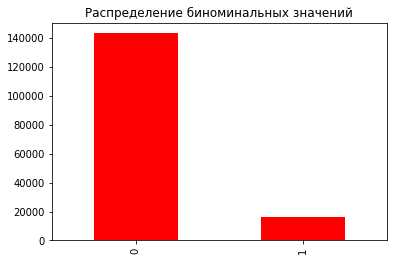

In [6]:
# Распределение целевого признака
toxic['toxic'].value_counts().plot(kind='bar', color = 'red')
plt.title('Распределение биноминальных значений')

In [7]:
# Функция для увеличение выборки
def upsample(features, target, repeat): 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]  
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [8]:
corpus = toxic['text']

In [9]:
# Функция для лемматизации и очистки комментариев
def clear_text(text):
    clean = nlp(text)
    clean = " ".join([token.lemma_ for token in clean])
    clean = re.sub(r'[^a-zA-Z]',' ',clean)
  
    return " ".join(clean.split())

In [10]:
# Применение модели spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [11]:
%%time
# Лемматизация и очистка комментариев
toxic_lemma=corpus.apply(clear_text)
toxic_lemma[:1]

CPU times: user 20min 34s, sys: 2.14 s, total: 20min 36s
Wall time: 20min 45s


0    explanation why the edit make under PRON usern...
Name: text, dtype: object

In [12]:
# Установление признака и целевого признака
target = toxic['toxic']
features = toxic.drop(['toxic'], axis=1)

In [13]:
# Отделение 20% данных для тестовой выборки, на обучающую- 80%
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(127656, 1) (31915, 1) (127656,) (31915,)


In [14]:
# Применение функции upsample
features_up,target_up=upsample(features_train,target_train,repeat=10)

Text(0.5, 1.0, 'Распределение биноминальных значений после обработки')

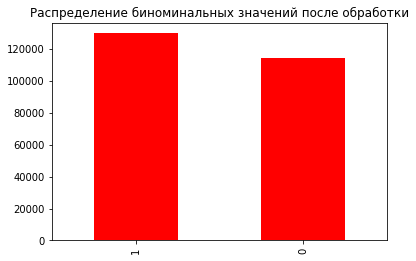

In [15]:
# Распределение целевого признака (с обработкой)
target_up.value_counts().plot(kind='bar', color = 'red')
plt.title('Распределение биноминальных значений после обработки')

In [16]:
# Загрузка стоп-слов
nltk.download("stopwords")
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Трансформация выборок в векторный вид TF-IDF
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tfid_train=count_tf_idf.fit_transform(features_up)
tfid_test=count_tf_idf.transform(features_test)

### Вывод:
При подготовке данных для обучения модели помимо разделения выборок произведена их балансировка с помощью метода upsample, лемматизация и очистка комментариев, загружены "stopwords" с помощью NLTK, данные приведены в векторный вид TF-IDF.

## Обучение

In [18]:
# Обучение LogisticRegression на случайных выборках
toxic_features_up=pd.DataFrame(features_up)
toxic_target_up=pd.DataFrame(target_up)
toxic_BERT_features=toxic_features_up.sample(n=50,random_state=12345)
toxic_BERT_target=target_up[toxic_BERT_features.index]
toxic_BERT_target = toxic_BERT_target.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

In [19]:
tokenizer = transformers.BertTokenizer(
    vocab_file='/datasets/ds_bert/vocab.txt')
tokenized = toxic_BERT_features['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))
max_len = max(tokenized.apply(lambda x: len(x)))
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

config = transformers.BertConfig.from_json_file(
    '/datasets/ds_bert/bert_config.json')
model = transformers.BertModel.from_pretrained(
    '/datasets/ds_bert/rubert_model.bin', config=config)

In [20]:
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [21]:
features = np.concatenate(embeddings)
features.shape

(50, 768)

In [22]:
target=toxic_BERT_target
target.shape

(50, 1)

In [23]:
# Отделение выборок, для корректного тестирования 50:50
features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.5,random_state=12345)

In [24]:
# Обучение модели
model=LogisticRegression().fit(features_train,target_train)

predict=model.predict(features_test)
accuracy=accuracy_score(predict,target_test)

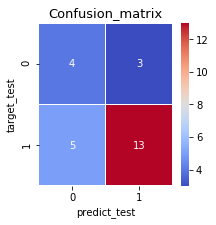

In [25]:
# Confusion_matrix
confusion_matrix_bert = confusion_matrix(predict,target_test)

f, ax=plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix_bert,annot=True,linewidths=0.5,cmap ='coolwarm',fmt=".0f",ax=ax)
plt.xlabel("predict_test")
plt.ylabel("target_test")
plt.title('Confusion_matrix', size = 13)
plt.show()

In [26]:
# Предсказание модели на тесте
lr_f1=round(f1_score(predict,target_test),2)
print('F1 of LogisticRegression = {0:.2f}'.format(lr_f1))

F1 of LogisticRegression = 0.76


### Вывод:
Проведено обучение LogisticRegression на случайных выборках с  использованием BertTokenizer (batch_size = 50).

## Выводы

In [39]:
scores_result = pd.DataFrame([lr_f1],
                           columns = ['F1_test >0.75'],
                           index = ['LogisticRegression'])

scores_result

,F1_test >0.75
LogisticRegression,0.76


### Вывод:
По итогу обучения LogisticRegression показала F1_test >0.75, что соответствует заданному условию для ***модели, которая будет искать токсичные комментарии*** и отправлять их на модерацию.